# YOLOv11 Nano: Plate Text Splitter

Train a lightweight model to separate license text and province text on cropped plate images. Uses the same bbox parsing as visualizing_splitter but writes a YOLO dataset of plate crops with two classes: 0=license_text, 1=province_text. Skip samples with more than two text regions (e.g., truck three-line plates).


In [2]:
# Setup: deps, paths, constants
# %pip install -q pandas numpy scikit-learn ultralytics matplotlib opencv-python
import random
from pathlib import Path
import ast
import shutil
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Reproducibility
random.seed(42)
np.random.seed(42)

# Paths (adjust PROJECT_ROOT if local)
# PROJECT_ROOT = Path('/content/ALPRV2')  # change to your root, e.g., Path(r'C:\\Users\\Tanaphat\\Desktop\\Coding\\ALPR')
PROJECT_ROOT = Path('C:\\Users\\Tanaphat\\Desktop\\Coding\\ALPR')
DATA_DIR = PROJECT_ROOT / 'data' / '8000'
CSV_PATH = DATA_DIR / '8000.csv'
DATASET_DIR = PROJECT_ROOT / 'train_lastest' / 'yolo_splitter_dataset'
YAML_PATH = DATASET_DIR / 'plate_splitter.yaml'

CLASS_NAMES = ['license_text', 'province_text']  # 0=license line, 1=province line

print(f'CSV: {CSV_PATH}')
print(f'Dataset out: {DATASET_DIR}')

CSV: C:\Users\Tanaphat\Desktop\Coding\ALPR\data\8000\8000.csv
Dataset out: C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_splitter_dataset


In [3]:
# Helper functions: parsing, geometry, I/O
def parse_single_bbox(bbox_str):
    try:
        arr = ast.literal_eval(bbox_str)
        if isinstance(arr, list) and len(arr) > 0:
            return arr[0]
    except Exception:
        return None
    return None


def parse_polygons(poly_str):
    try:
        arr = ast.literal_eval(poly_str)
        if isinstance(arr, list) and len(arr) > 0:
            return [np.array(p) for p in arr]
    except Exception:
        return []
    return []


def polygon_to_xyxy(poly):
    x_min, y_min = poly[:, 0].min(), poly[:, 1].min()
    x_max, y_max = poly[:, 0].max(), poly[:, 1].max()
    return [x_min, y_min, x_max, y_max]


def clamp_bbox(bbox, w, h):
    x1, y1, x2, y2 = bbox
    x1 = max(0, min(x1, w))
    x2 = max(0, min(x2, w))
    y1 = max(0, min(y1, h))
    y2 = max(0, min(y2, h))
    return [x1, y1, x2, y2]


def to_yolo_xywh(bbox, w, h):
    x1, y1, x2, y2 = bbox
    xc = (x1 + x2) / 2.0
    yc = (y1 + y2) / 2.0
    bw = x2 - x1
    bh = y2 - y1
    return [xc / w, yc / h, bw / w, bh / h]


def load_image_cv2(img_path: Path):
    img_array = np.fromfile(str(img_path), dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f'Cannot load image: {img_path}')
    return img


def save_image_cv2(img_path: Path, img):
    img_path.parent.mkdir(parents=True, exist_ok=True)
    success, buf = cv2.imencode(img_path.suffix or '.jpg', img)
    if not success:
        raise ValueError(f'Failed to encode image for {img_path}')
    img_path.write_bytes(buf.tobytes())

In [4]:
# Load CSV and keep usable rows (<=2 text regions)
df = pd.read_csv(CSV_PATH)
print(f'Total rows: {len(df)}')
mask = (
    df['is_validate'] == True
) & df['car_bbox'].notna() & df['plate_bbox'].notna() & df['character_bbox'].notna()
df = df[mask].copy()
print(f'Validated with bboxes: {len(df)}')

df['car_bbox_parsed'] = df['car_bbox'].apply(parse_single_bbox)
df['plate_bbox_parsed'] = df['plate_bbox'].apply(parse_single_bbox)
df['char_polys'] = df['character_bbox'].apply(parse_polygons)

# Keep samples with 1 or 2 text regions only
df['char_count'] = df['char_polys'].apply(len)
df = df[(df['char_count'] >= 1) & (df['char_count'] <= 2)].copy()
print(f'After removing >2 text regions: {len(df)}')

# Resolve image paths
def resolve_image_path(row):
    img_rel = row['image_name_gray'] if 'image_name_gray' in row and isinstance(row['image_name_gray'], str) else row['image_name']
    return (DATA_DIR / img_rel.lstrip('/')).resolve()

df['img_path'] = df.apply(resolve_image_path, axis=1)
print(df[['img_path','char_count']].head())

Total rows: 8172
Validated with bboxes: 8172
After removing >2 text regions: 8069
                                            img_path  char_count
0  C:\Users\Tanaphat\Desktop\Coding\ALPR\data\800...           2
1  C:\Users\Tanaphat\Desktop\Coding\ALPR\data\800...           2
2  C:\Users\Tanaphat\Desktop\Coding\ALPR\data\800...           2
3  C:\Users\Tanaphat\Desktop\Coding\ALPR\data\800...           2
4  C:\Users\Tanaphat\Desktop\Coding\ALPR\data\800...           2


In [5]:
# Build YOLO-format dataset of cropped plates with text labels
splits = {'train': 0.7, 'val': 0.2, 'test': 0.1}
if abs(sum(splits.values()) - 1.0) > 1e-6:
    raise ValueError('Split ratios must sum to 1')

# Reset dataset dir
if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
for split in splits.keys():
    (DATASET_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (DATASET_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

rows = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
n = len(rows)
train_end = int(n * splits['train'])
val_end = train_end + int(n * splits['val'])

def choose_split(i):
    if i < train_end:
        return 'train'
    elif i < val_end:
        return 'val'
    else:
        return 'test'

written = {'train': 0, 'val': 0, 'test': 0}
skipped = 0

for i, row in rows.iterrows():
    split = choose_split(i)
    try:
        car_bbox = row['car_bbox_parsed']
        plate_rel = row['plate_bbox_parsed']
        char_polys = row['char_polys']
        if car_bbox is None or plate_rel is None or len(char_polys) == 0:
            skipped += 1
            continue

        img = load_image_cv2(row['img_path'])
        h, w = img.shape[:2]
        cx1, cy1, cx2, cy2 = car_bbox
        px1, py1, px2, py2 = plate_rel
        plate_abs = [px1 + cx1, py1 + cy1, px2 + cx1, py2 + cy1]
        plate_abs = clamp_bbox(plate_abs, w, h)
        x1, y1, x2, y2 = map(int, plate_abs)
        if x2 <= x1 or y2 <= y1:
            skipped += 1
            continue

        plate_crop = img[y1:y2, x1:x2]
        ph, pw = plate_crop.shape[:2]
        if ph < 2 or pw < 2:
            skipped += 1
            continue

        # Build labels from polygons (already plate-relative)
        labels = []
        for j, poly in enumerate(char_polys):
            box = polygon_to_xyxy(np.array(poly))
            box = clamp_bbox(box, pw, ph)
            bx1, by1, bx2, by2 = box
            if bx2 <= bx1 or by2 <= by1:
                continue
            cls_id = 0 if j == 0 else 1
            yolo_box = to_yolo_xywh(box, pw, ph)
            labels.append((cls_id, *yolo_box))

        if len(labels) == 0:
            skipped += 1
            continue

        img_name = f'{split}_{i}.jpg'
        label_name = f'{split}_{i}.txt'
        img_out = DATASET_DIR / 'images' / split / img_name
        lbl_out = DATASET_DIR / 'labels' / split / label_name

        save_image_cv2(img_out, plate_crop)
        with open(lbl_out, 'w') as f:
            for cls_id, xc, yc, bw, bh in labels:
                f.write(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

        written[split] += 1
    except Exception as e:
        skipped += 1
        print(f'Skip idx {i} ({row.get("img_path", "?")}) -> {e}')

print(f"Written: train={written['train']}, val={written['val']}, test={written['test']}")
print(f'Skipped: {skipped}')

Written: train=5648, val=1613, test=808
Skipped: 0


In [ ]:
# Write dataset YAML
yaml_content = f"""# Plate text splitter (cropped plates)
path: {DATASET_DIR}
train: images/train
val: images/val
test: images/test

names:
  0: {CLASS_NAMES[0]}
  1: {CLASS_NAMES[1]}
"""
YAML_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(YAML_PATH, 'w') as f:
    f.write(yaml_content)
print(f'YAML saved to {YAML_PATH}')
print(yaml_content)

YAML saved to C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_splitter_dataset\plate_splitter.yaml
# Plate text splitter (cropped plates)
path: C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_splitter_dataset
train: images/train
val: images/val
test: images/test

names:
  0: license_text
  1: province_text



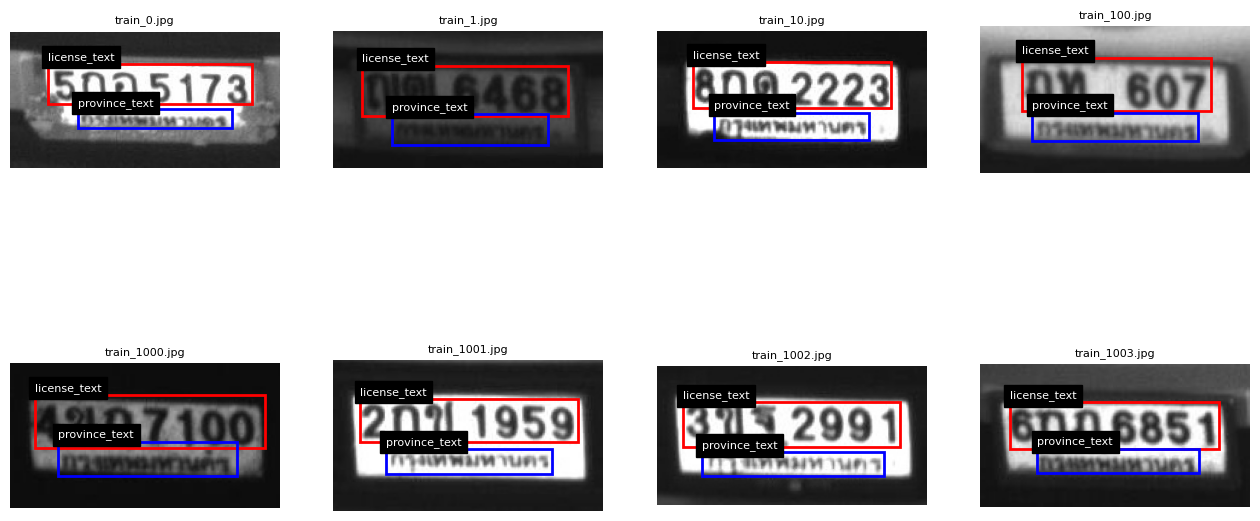

In [7]:
# Quick visualize a few cropped plate samples with labels
def visualize_samples(split='train', num_samples=12, cols=4):
    img_dir = DATASET_DIR / 'images' / split
    label_dir = DATASET_DIR / 'labels' / split
    imgs = sorted(img_dir.glob('*'))[:num_samples]
    if not imgs:
        print(f'No images found in {img_dir}')
        return
    cols = max(1, cols)
    rows = (len(imgs) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = np.array(axes).reshape(rows, cols)
    flat_axes = axes.flatten()
    for ax, img_path in zip(flat_axes, imgs):
        img = cv2.imdecode(np.fromfile(str(img_path), dtype=np.uint8), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        ax.imshow(img)
        label_path = label_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls_id, xc, yc, bw, bh = map(float, line.strip().split())
                    x1 = (xc - bw/2) * w
                    y1 = (yc - bh/2) * h
                    rect = patches.Rectangle((x1, y1), bw*w, bh*h, linewidth=2, edgecolor='red' if int(cls_id)==0 else 'blue', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1-3, CLASS_NAMES[int(cls_id)], color='white', fontsize=8, backgroundcolor='black')
        ax.axis('off')
        ax.set_title(img_path.name, fontsize=8)
    for ax in flat_axes[len(imgs):]:
        ax.axis('off')
    plt.show()

visualize_samples('train', num_samples=8, cols=4)

In [4]:
# Train YOLOv11 nano on plate splitter dataset
model = YOLO('yolo11n.pt')
print('Model loaded')

results = model.train(
    data=str(YAML_PATH),
    epochs=80,
    imgsz=640,
    batch=16,
    name='plate_splitter_nano',
    patience=15,
    device=0,   # set to 'cpu' if no GPU
    workers=2,
    project='runs/detect',
    exist_ok=True,
    optimizer='auto',
    cos_lr=True,
    augment=True,
    amp=True,
 )
print(f'Training complete. Artifacts: {results.save_dir}')

Model loaded
Ultralytics 8.3.241  Python-3.11.13 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=C:\Users\Tanaphat\Desktop\Coding\ALPR\train_lastest\yolo_splitter_dataset\plate_splitter.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=plate_splitter_nano, nbs=64, nms=False, opset=No